In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier



from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor


from textwrap import wrap
from functools import reduce

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, get_categorical_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances, feature_selection_mutual_info_regression, recursive_feature_elimination, get_permutation_importance

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age
600,1,NaN,NaN,NaN,56.0,161.0,21.604105,104.0,62.0,0.0,70.0,0.0,79.0,0.886076,1.0,1.0,0.434783,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,7.140000,3.996000,11.136000,0.0,1.0,11.32,10.86,22.18,1.0,7.28,4.90,1.82,0.46,0.08,0.02,67.3,25.0,6.3,1.1,0.3,4.21,12.1,36.6,3.024793,86.9,28.7,33.1,13.1,285.0,10.1,9.5,20.3,39.148352,0.033333,156.593407,3.956522,2.692308,0.250000,0.010989,142.0,4.36,9.87,NaN,0.82,NaN,15.0,21.0,0.38,169.0,4.37034,0.0,70.0,1.81020,0.0,80.6,2.084316,0.0,90.0,1.01610,1.151429,1.285714,0.952488,31.068323,12.19320,4.447129,0.109144,NaN,NaN,NaN,NaN,NaN,81.0,124.0,8.53,78.65,1.706000,5.69,0.352183,0.07,4.57,18.80,43.0,266.0,3.5,6.7,1.914286,140.0,362.0,2.20,0.634006,0.035484,48.895454,NaN,354.0,361.0,31.0,62.0,3.51,11.52,NaN,NaN,4.02,1.52,614.0,0.003583,0.547264,23.0
962,4,227.0,NaN,NaN,60.0,175.0,19.591837,119.0,82.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,4.218074,3.549390,7.767464,NaN,NaN,6.84,6.01,12.85,0.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.21,15.5,44.7,2.883871,85.8,29.2,34.0,13.8,254.0,12.7,10.6,29.9,76.506024,0.041732,NaN,NaN,NaN,NaN,NaN,142.0,4.69,10.09,4.18,0.81,3.9,13.0,16.0,0.66,170.0,4.39620,0.0,67.0,1.73262,0.0,98.0,2.534280,0.0,56.0,0.63224,1.462687,0.835821,NaN,NaN,NaN,4.251344,-0.077887,NaN,NaN,NaN,NaN,NaN,88.0,124.0,29.90,NaN,6.496790,NaN,0.292385,3.00,5.12,16.50,20.0,17.0,3.9,6.0,1.538462,648.0,615.0,2.26,0.651297,0.038699,159.681415,31.40,644.0,554.0,104.0,58.4,3.87,51.60,NaN,NaN,3.75,1.61,523.0,0.004321,0.602667,NaN
916,4,NaN,NaN,NaN,96.0,167.0,34.422174,

### Handle `vitamine D ` outliers

In [3]:
df[VITAMINE_D].mean()

25.551785714285714

In [4]:
df[VITAMINE_D].std()

12.965793597129847

In [5]:
25.5+13+13+13

64.5

In [6]:
df[df[VITAMINE_D] > 64.5][VITAMINE_D]

92      66.0
219     89.0
542     66.0
831     73.0
872     82.0
975    129.0
Name: vitamin 25-OH D ng/ml, dtype: float64

In [7]:
df.loc[df[VITAMINE_D] > 64.5, VITAMINE_D] = np.nan

<Axes: >

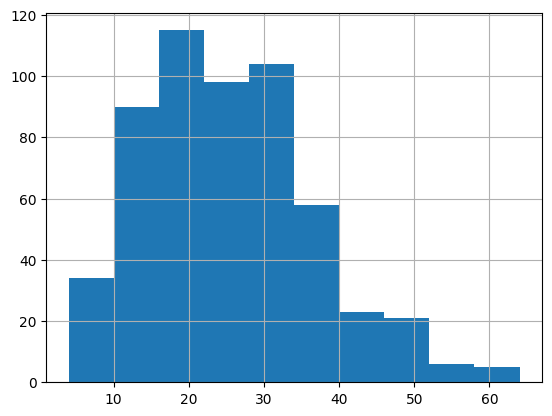

In [8]:
df[VITAMINE_D].hist()

# Model selection for vitamin D

In [9]:
df_vit_d_cleaned = df.dropna(subset=[VITAMINE_D])

X_vit_d, y_vit_d = df_vit_d_cleaned.drop(columns=[VITAMINE_D]), df_vit_d_cleaned[VITAMINE_D]
X_train_vit_d, X_test_vit_d, y_train_vit_d, y_test_vit_d = train_test_split(X_vit_d, y_vit_d, test_size=0.2, random_state=42)

Best preprocessing techniques for vitamine D:
- PT_KNN  + original_ohe_no_imputing

In [10]:
tree_continuous_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])
linear_continuous_preprocessor =  Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9)), ('poly',  PolynomialFeatures(degree=2, interaction_only=True))])

# continuous_preprocessor = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=9))])
# linear_continuous_preprocessor =  Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=9)), ('poly',  PolynomialFeatures(degree=2, interaction_only=True))])

# categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])
categorical_preprocessor = Pipeline([('imputer', IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=10, n_jobs=-1), max_iter=40, initial_strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])


### Hyperparameter tuning

### Lasso

Lasso with polynomial features

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best parameters: {'model__alpha': 1}
Best score (neg_mean_absolute_error): -8.710032970277023


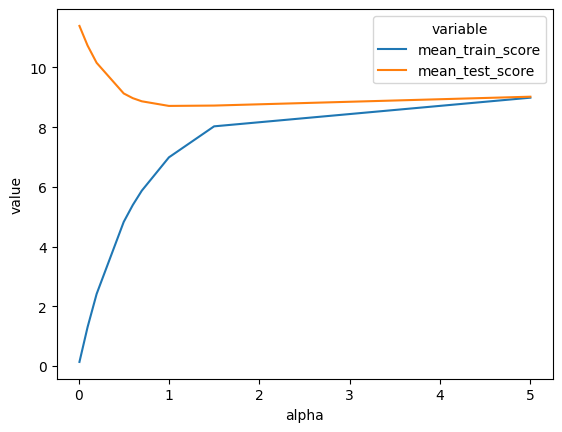

,alpha,mean_train_score,mean_test_score
0,0.01,0.140187,11.387913
1,0.1,1.305675,10.730554
2,0.2,2.414885,10.153626
3,0.5,4.827742,9.127120
4,0.6,5.390699,8.970097
5,0.7,5.872792,8.864744
6,1,6.987976,8.710033
7,1.5,8.026328,8.721792
8,5,8.985761,9.018594


In [28]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
}

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), linear_continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

C=0.5

Lasso with regular features

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best parameters: {'model__alpha': 0.6}
Best score (neg_mean_absolute_error): -8.53146054969854


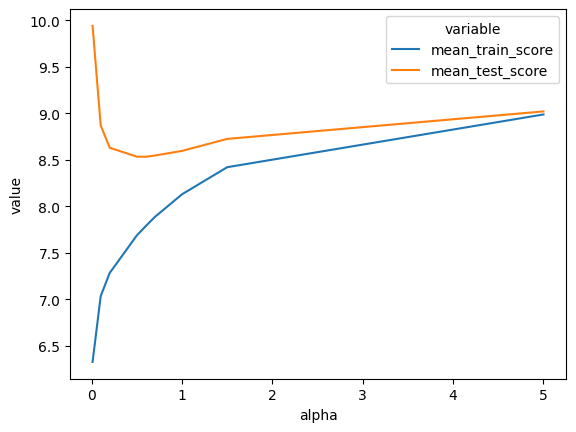

,alpha,mean_train_score,mean_test_score
0,0.01,6.325230,9.937780
1,0.1,7.032682,8.866931
2,0.2,7.282339,8.627873
3,0.5,7.685633,8.532239
4,0.6,7.787173,8.531461
5,0.7,7.884552,8.544234
6,1,8.127694,8.594232
7,1.5,8.418870,8.723130
8,5,8.985761,9.018594


In [29]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

Selected alpha: 0.2

### Ridge

Rigde + polynomial features

Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best parameters: {'model__alpha': 1000}
Best score (neg_mean_absolute_error): -9.510787208833584


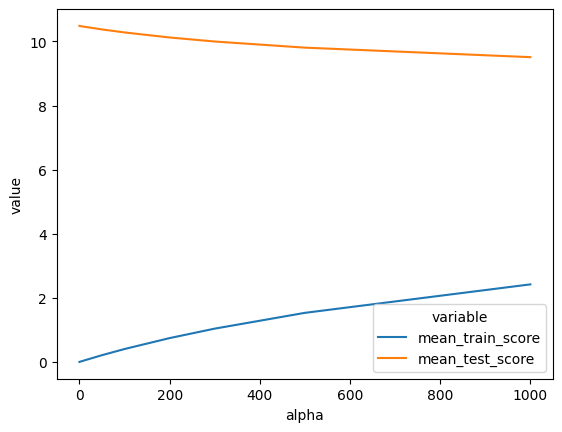

,alpha,mean_train_score,mean_test_score
0,0.000001,4.417973e-09,10.485612
1,0.01,4.417929e-05,10.485588
2,0.1,4.417533e-04,10.485370
3,1,4.413583e-03,10.483195
4,10,4.374578e-02,10.462049
5,50,2.105833e-01,10.376311
6,100,4.029228e-01,10.282001
7,200,7.437959e-01,10.124766
8,300,1.039001e+00,9.998972
9,500,1.531725e+00,9.807763


In [36]:
ridge_param_grid = {
    "model__alpha": [0.000001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 500, 1000, 1000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), linear_continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Rigde

Fitting 15 folds for each of 6 candidates, totalling 90 fits
Best parameters: {'model__alpha': 500}
Best score (neg_mean_absolute_error): -8.49180752043109


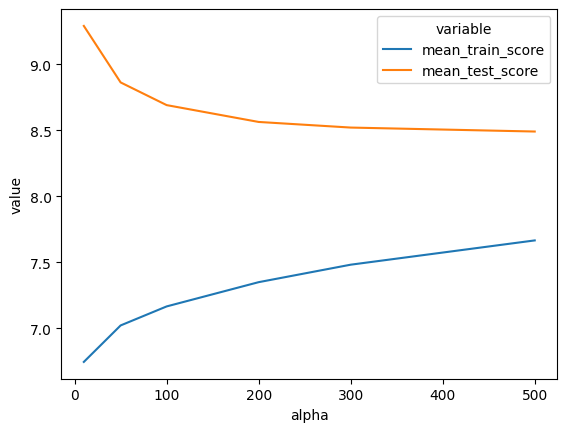

,alpha,mean_train_score,mean_test_score
0,10,6.745464,9.292248
1,50,7.022055,8.863978
2,100,7.166139,8.692041
3,200,7.350007,8.564375
4,300,7.482459,8.521817
5,500,7.666460,8.491808


In [37]:
ridge_param_grid = {
    "model__alpha": [10, 50, 100, 200, 300, 500],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Best alpha: 100 lub 200

### DecisionTreeRegressor

In [43]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [8, 9, 10, 12],
    # "model__splitter": ["random", "best"],
    "model__min_samples_split": [15, 16, 17, 20],
    "model__min_samples_leaf": [20, 22, 25, 27],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, tree_model, continuous_preprocessor, categorical_preprocessor, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 64 candidates, totalling 960 fits
Best parameters: {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}
Best score (neg_mean_absolute_error): -9.544982124616956


,params,mean_train_score,mean_test_score
62,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}",7.197525,9.544982
61,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}",7.197525,9.547255
45,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}",7.197525,9.549149
60,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}",7.197525,9.549511
29,"{'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}",7.197525,9.551783
47,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20}",7.200529,9.554503
28,"{'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}",7.186225,9.557763
14,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}",7.197525,9.560891
44,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}",7.197525,9.564611
63,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20}",7.186225,9.565288


In [11]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


,cv_mae
62,-9.07908
58,-9.187412
14,-9.191769
51,-9.192326
83,-9.193849


### Random Forest

In [42]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 5, 7],
    'model__min_samples_leaf': [3, 5, 7],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, RandomForestRegressor(criterion="absolute_error"), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


,params,mean_train_mae,mean_test_mae
8,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.047948,8.726923
15,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.544893,8.740124
1,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 200}",5.119564,8.741829
17,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 200}",6.547260,8.743113
16,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.558310,8.747370
7,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.049708,8.749739
14,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.570497,8.753219
13,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.547810,8.758884
9,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.038521,8.759326
10,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.066576,8.763497


In [43]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, criterion='absolute_error')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:45<00:00,  5.92s/it]


,cv_mae
13,-8.697161
16,-8.713622
7,-8.714204
61,-8.714876
72,-8.717986


#### SVR

In [39]:
param_grid_svr = {
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [0.1, 1, 10],
    'model__degree': [2],
    'model__epsilon': [0.1, 0.2, 0.3],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, SVR(), continuous_preprocessor, categorical_preprocessor, param_grid_svr)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 108 candidates, totalling 1620 fits


Best parameters: {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'linear'}
Best score (neg_mean_absolute_error): -8.871501308562694


,params,mean_train_score,mean_test_score
18,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'linear'}",6.751976,8.871501
21,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 1, 'model__kernel': 'linear'}",6.751976,8.871501
24,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 10, 'model__kernel': 'linear'}",6.751976,8.871501
12,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 1, 'model__kernel': 'linear'}",6.742408,8.876607
9,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 0.1, 'model__kernel': 'linear'}",6.742408,8.876607
15,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 10, 'model__kernel': 'linear'}",6.742408,8.876607
0,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'linear'}",6.732536,8.884952
3,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 1, 'model__kernel': 'linear'}",6.732536,8.884952
6,"{'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 10, 'model__kernel': 'linear'}",6.732536,8.884952
73,"{'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'rbf'}",2.352393,8.993749


## Best models for Vitamine D

#### Linear Regression

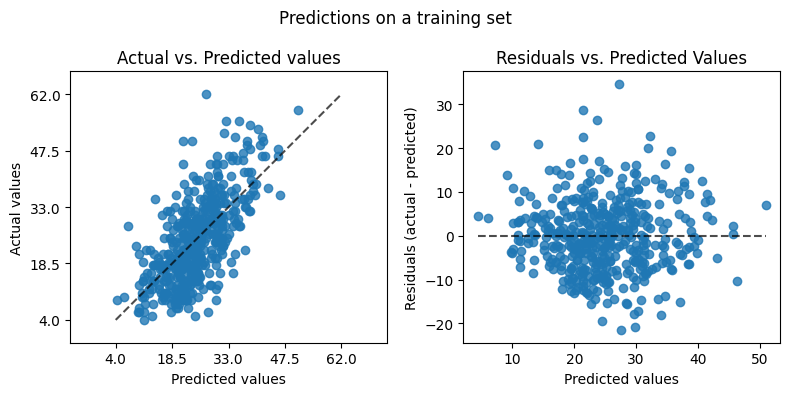

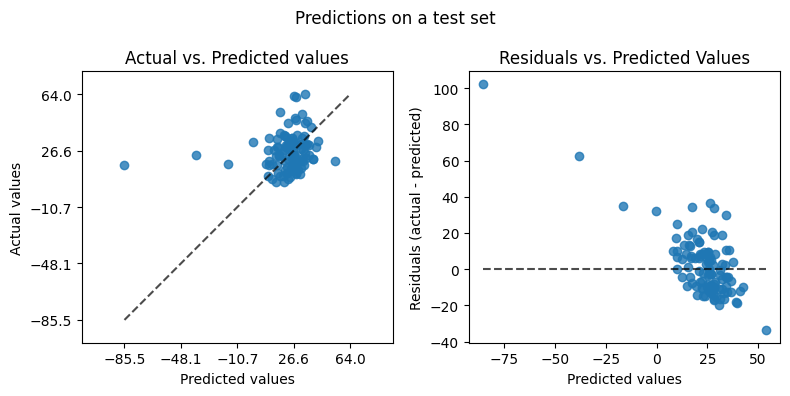

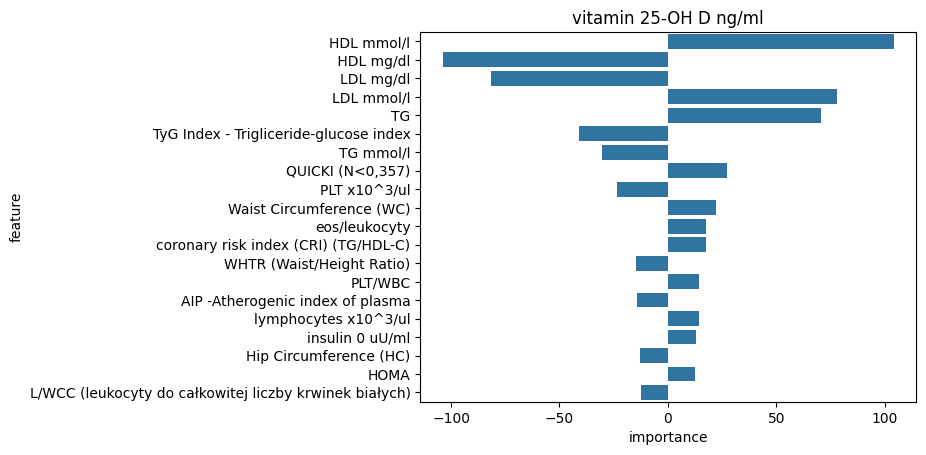

,model,data_set,mse,mae,rmse,r2
0,LinearRegression(),training,68.390,6.498,8.270,0.445
1,LinearRegression(),test,313.433,12.422,17.704,-1.220


In [11]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lasso = train_model(lr_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

#### Linear Regression with Polynomial Features

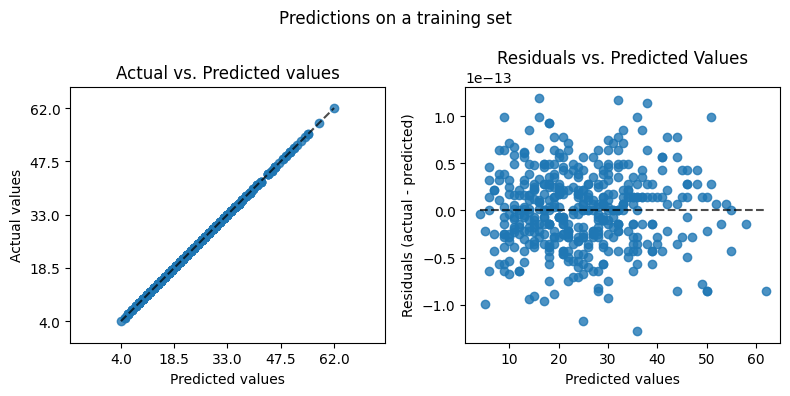

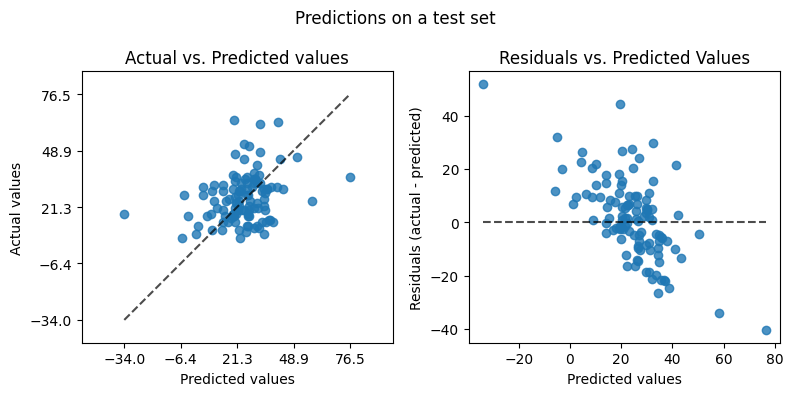

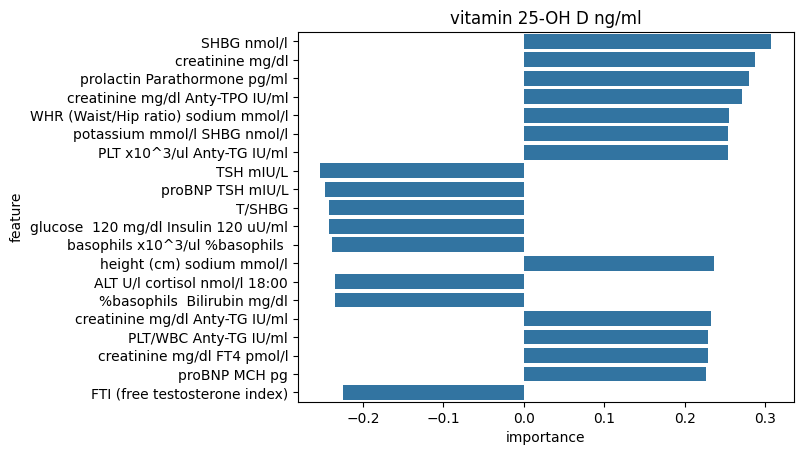

,model,data_set,mse,mae,rmse,r2
0,LinearRegression(),training,0.000,0.00,0.000,1.000
1,LinearRegression(),test,227.965,11.45,15.098,-0.615


In [14]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr_poly = train_model(lr_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Lasso + polynomial features

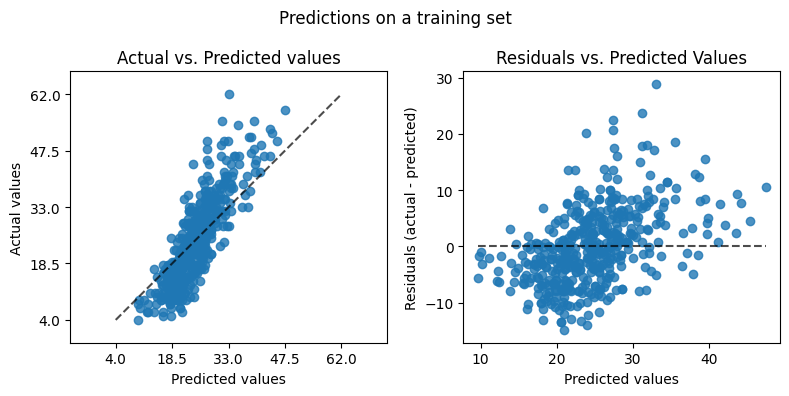

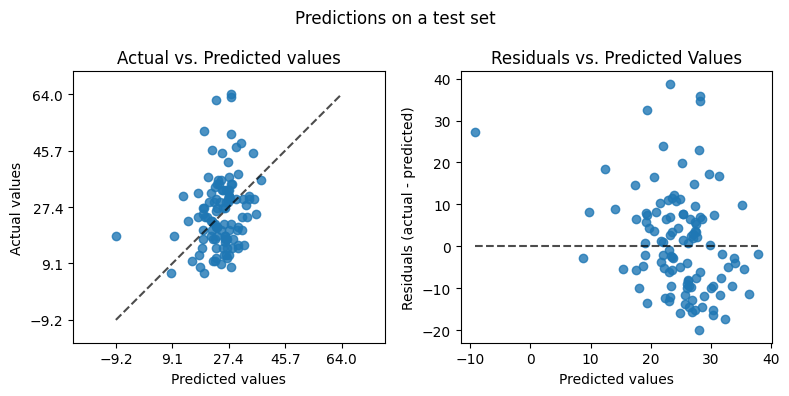

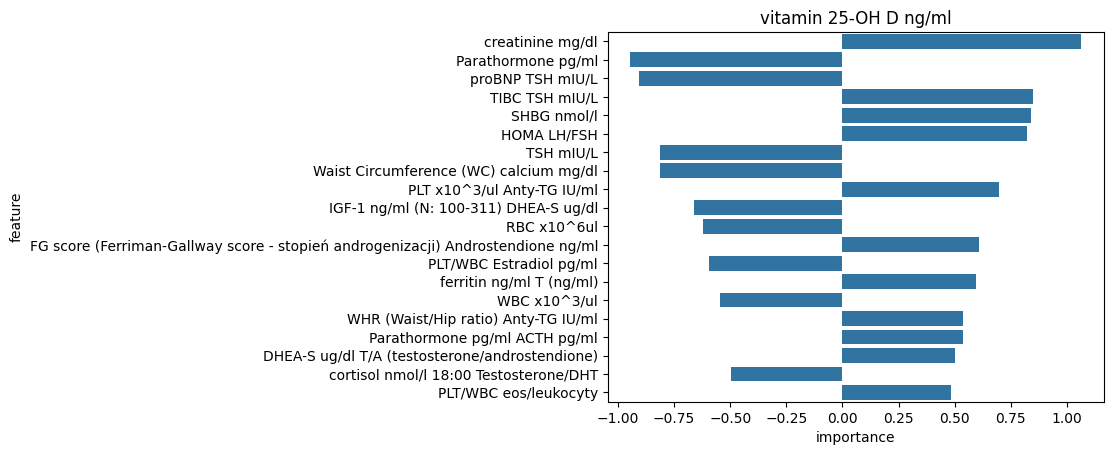

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=0.5),training,46.644,5.379,6.830,0.621
1,Lasso(alpha=0.5),test,146.060,9.517,12.086,-0.034


In [32]:
poly_lasso_model = Lasso(alpha=0.5)

vit_d_model_scores_df, feature_importnces_lasso = train_model(poly_lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Lasso without polynomial features

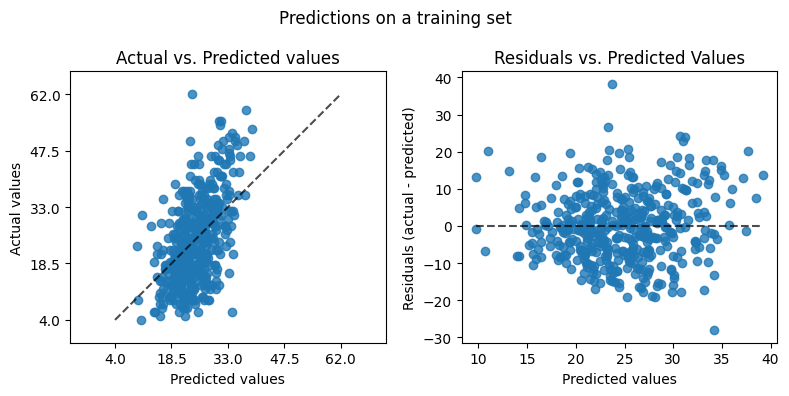

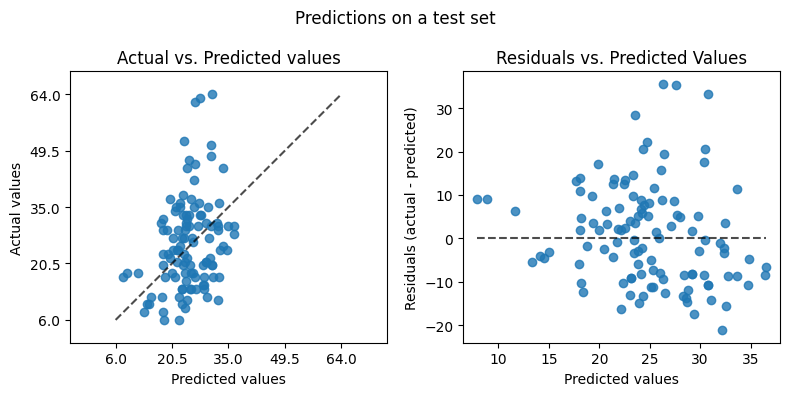

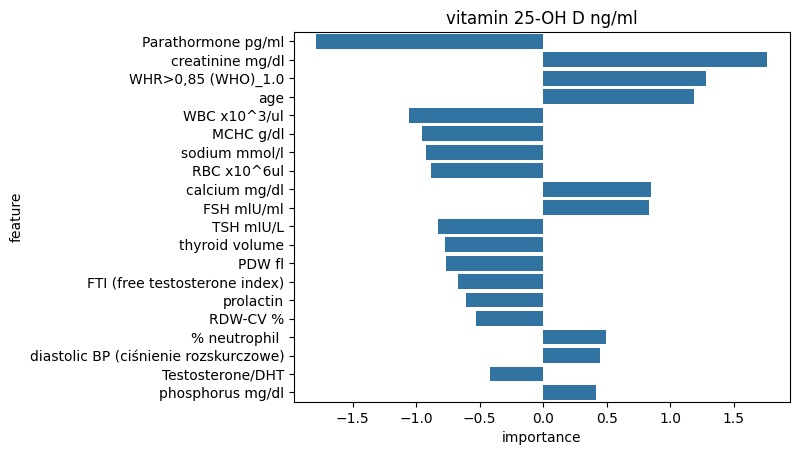

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=0.2),training,87.755,7.487,9.368,0.287
1,Lasso(alpha=0.2),test,134.793,9.319,11.610,0.045


In [15]:
lasso_model = Lasso(alpha=0.2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

#### Ridge

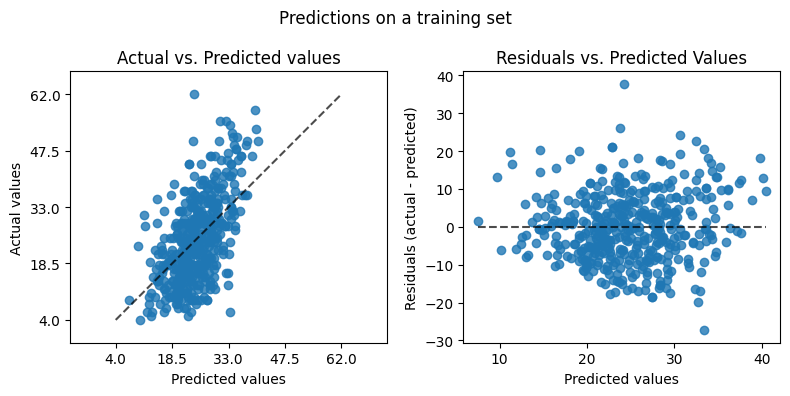

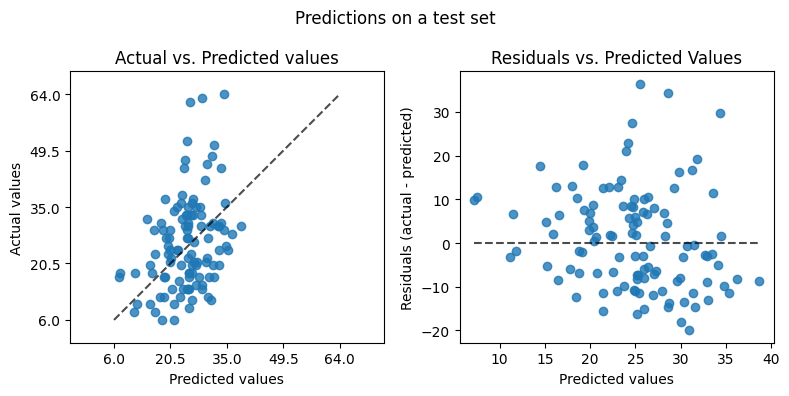

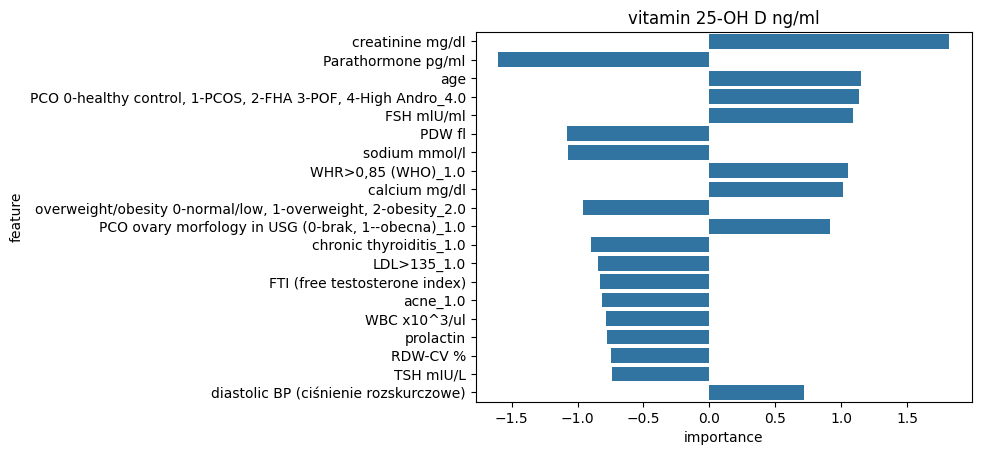

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=50),training,81.815,7.213,9.045,0.336
1,Ridge(alpha=50),test,130.993,9.295,11.445,0.072


In [16]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Decision Tree

In [ ]:
# {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}	

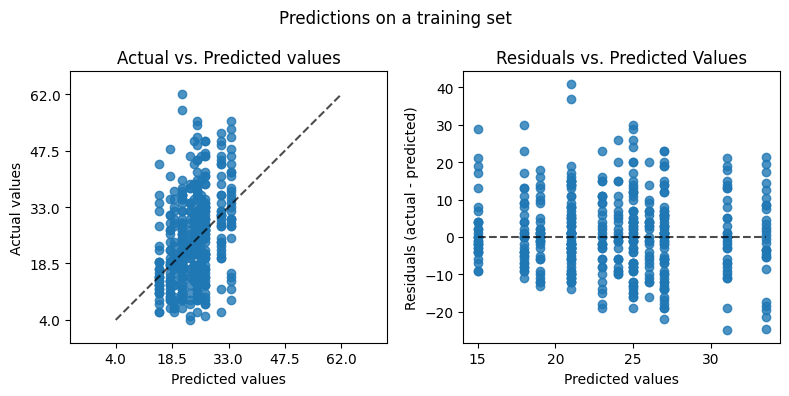

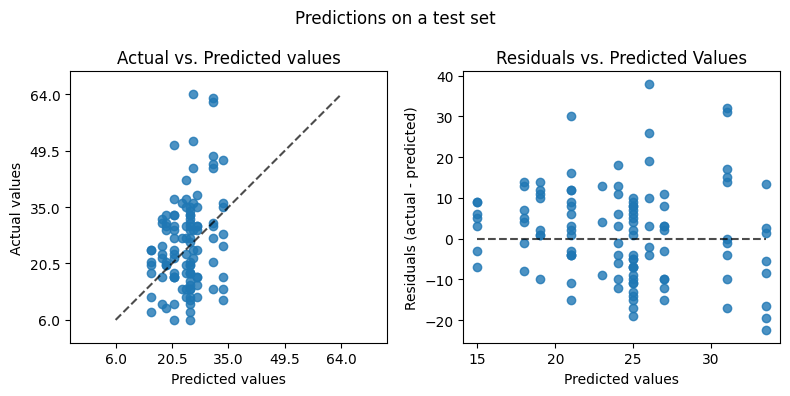

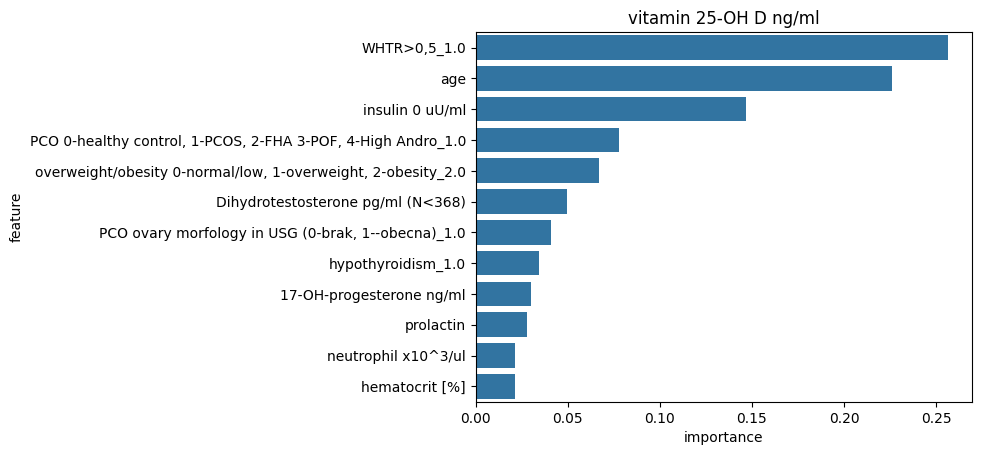

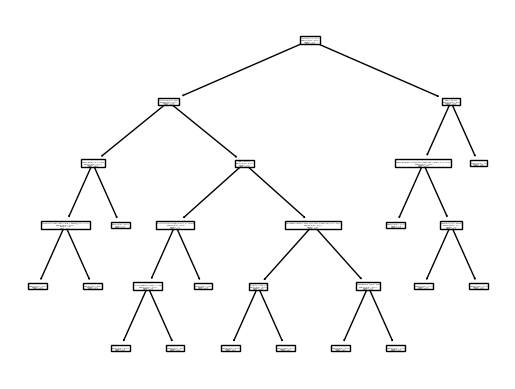

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=8,\n min_samples_leaf=27, min_samples_split=17,\n random_state=62, splitter='random')",training,107.65,7.907,10.375,0.126
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=8,\n min_samples_leaf=27, min_samples_split=17,\n random_state=62, splitter='random')",test,135.18,9.270,11.627,0.043


In [17]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=8, min_samples_leaf=27, min_samples_split=17, splitter='random', random_state=62)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

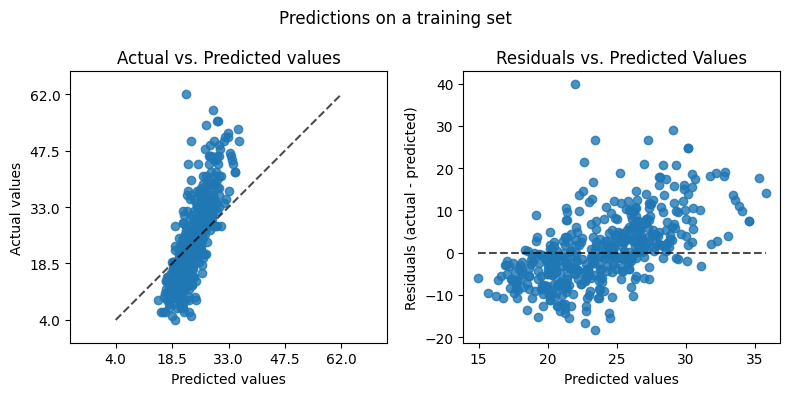

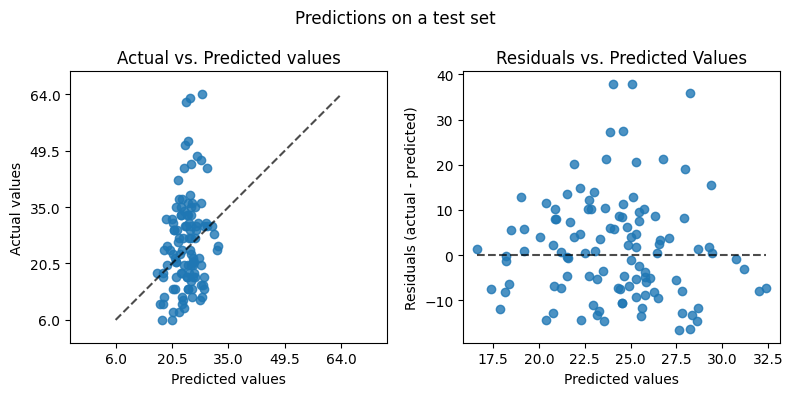

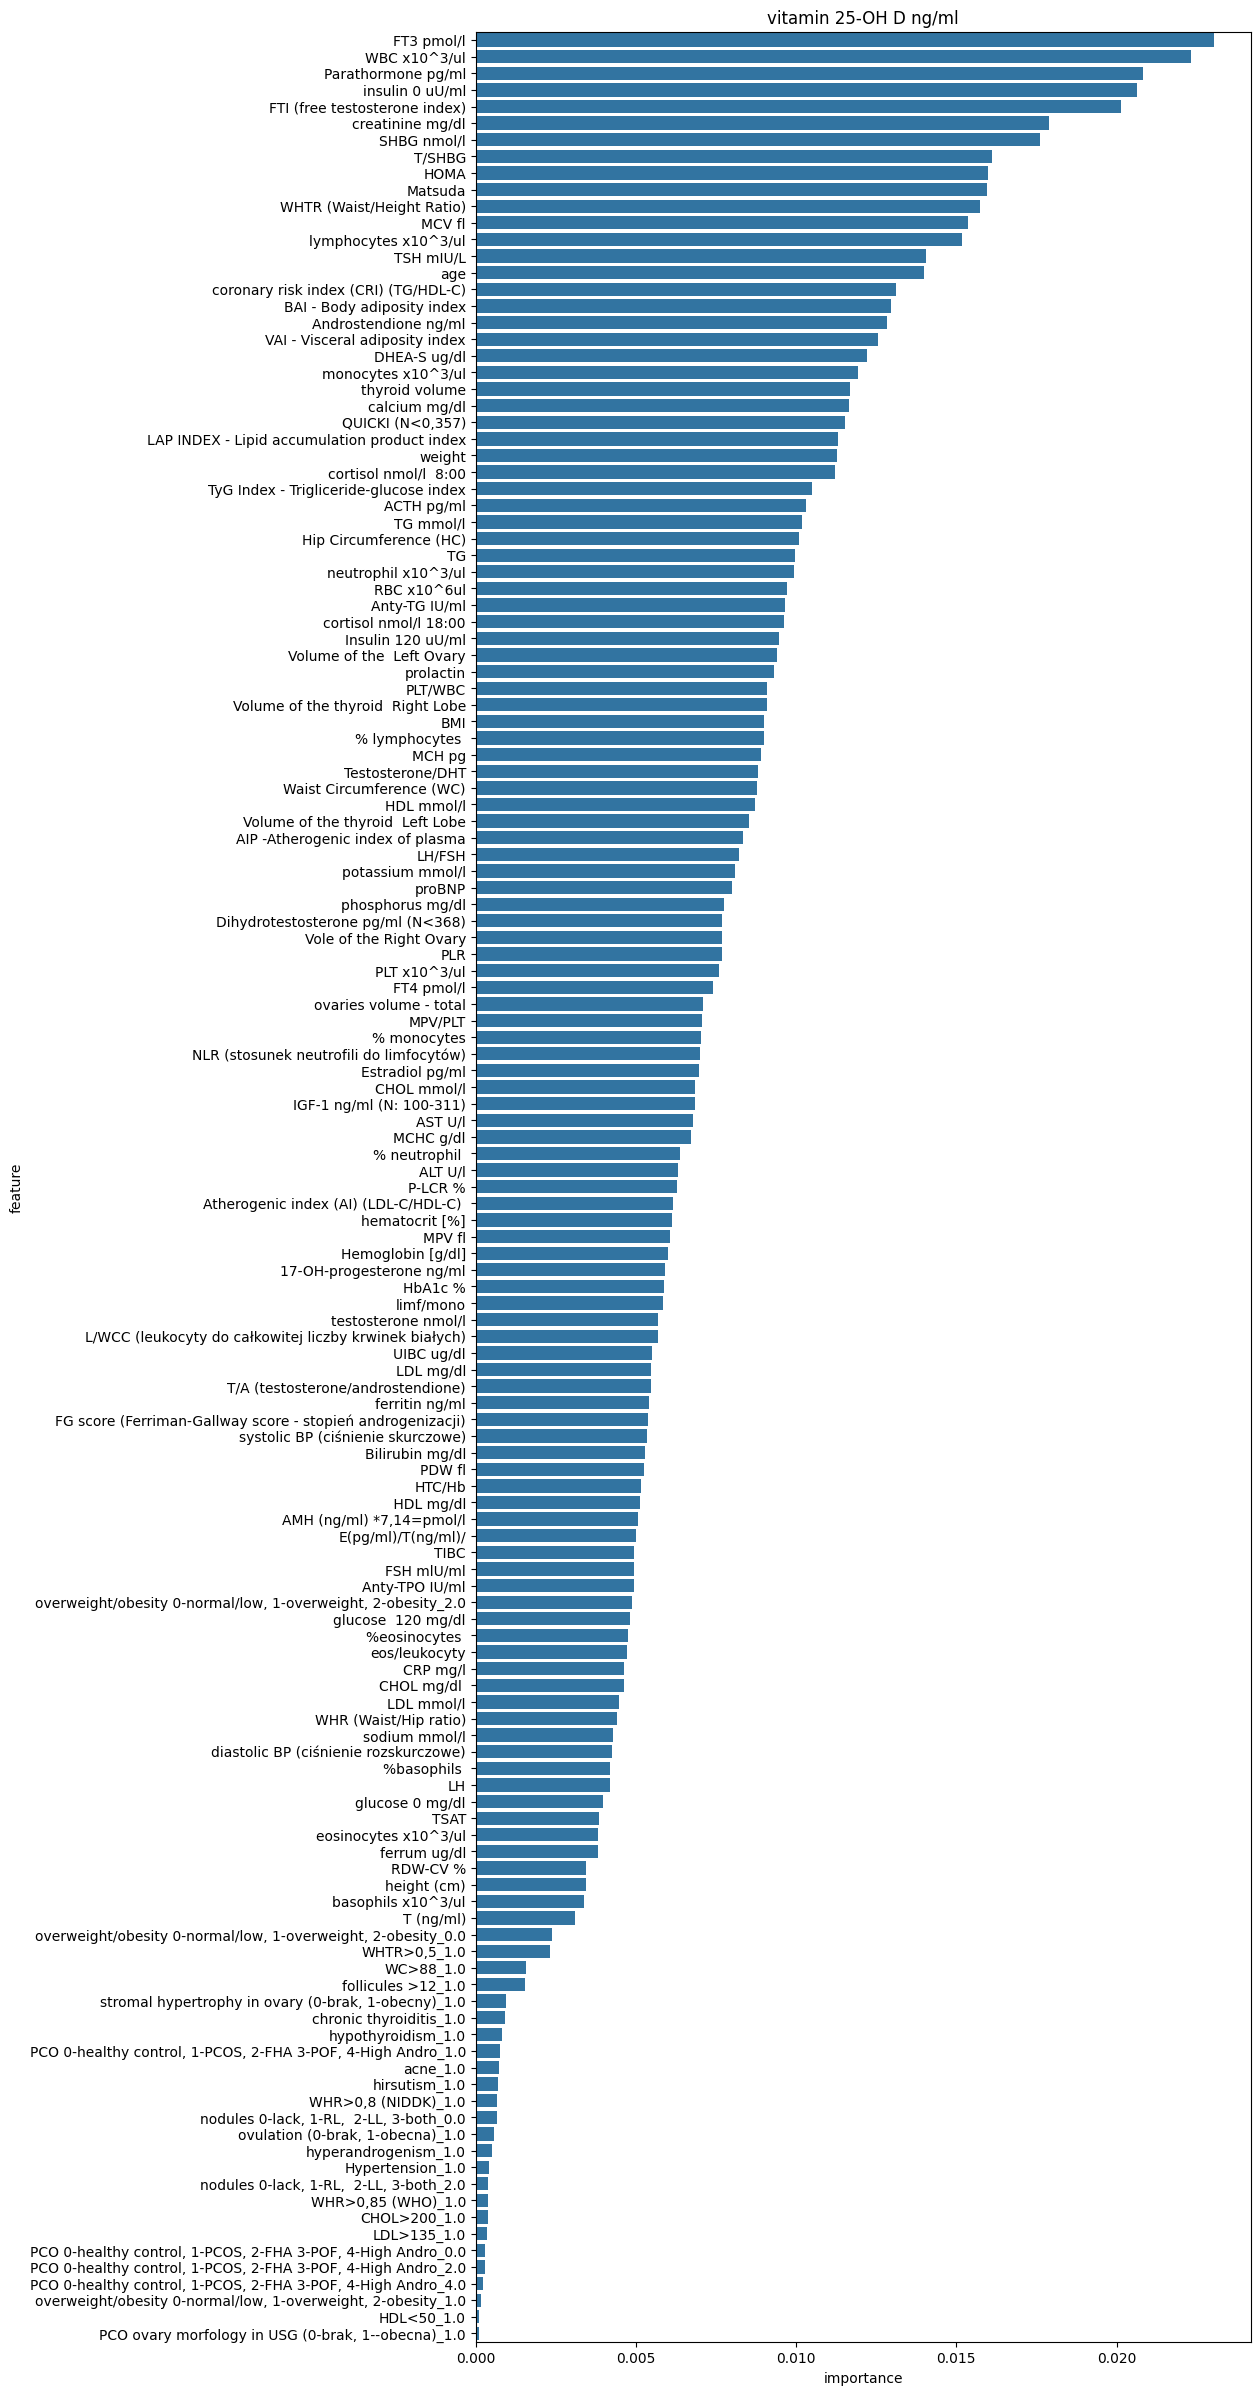

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",training,69.727,6.381,8.350,0.434
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",test,136.567,9.077,11.686,0.033


In [18]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

In [47]:
# svm_model = SVR(C=0.1, degree=2, epsilon=0.1, gamma=0.1, kernel='poly')
# vit_d_model_scores_df, feature_importnces_sv = train_model(svm_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, None)
# vit_d_model_scores_df

## Feature importances


In [19]:
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])
feature_importance_df.head(5)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance
0,HDL mg/dl,NaN,-0.144865,NaN,0.005123
1,% lymphocytes,NaN,-0.070301,NaN,0.008998
2,% monocytes,NaN,-0.008830,NaN,0.007031
3,% neutrophil,0.496136,0.503062,NaN,0.006365
4,%basophils,NaN,0.061622,NaN,0.004183


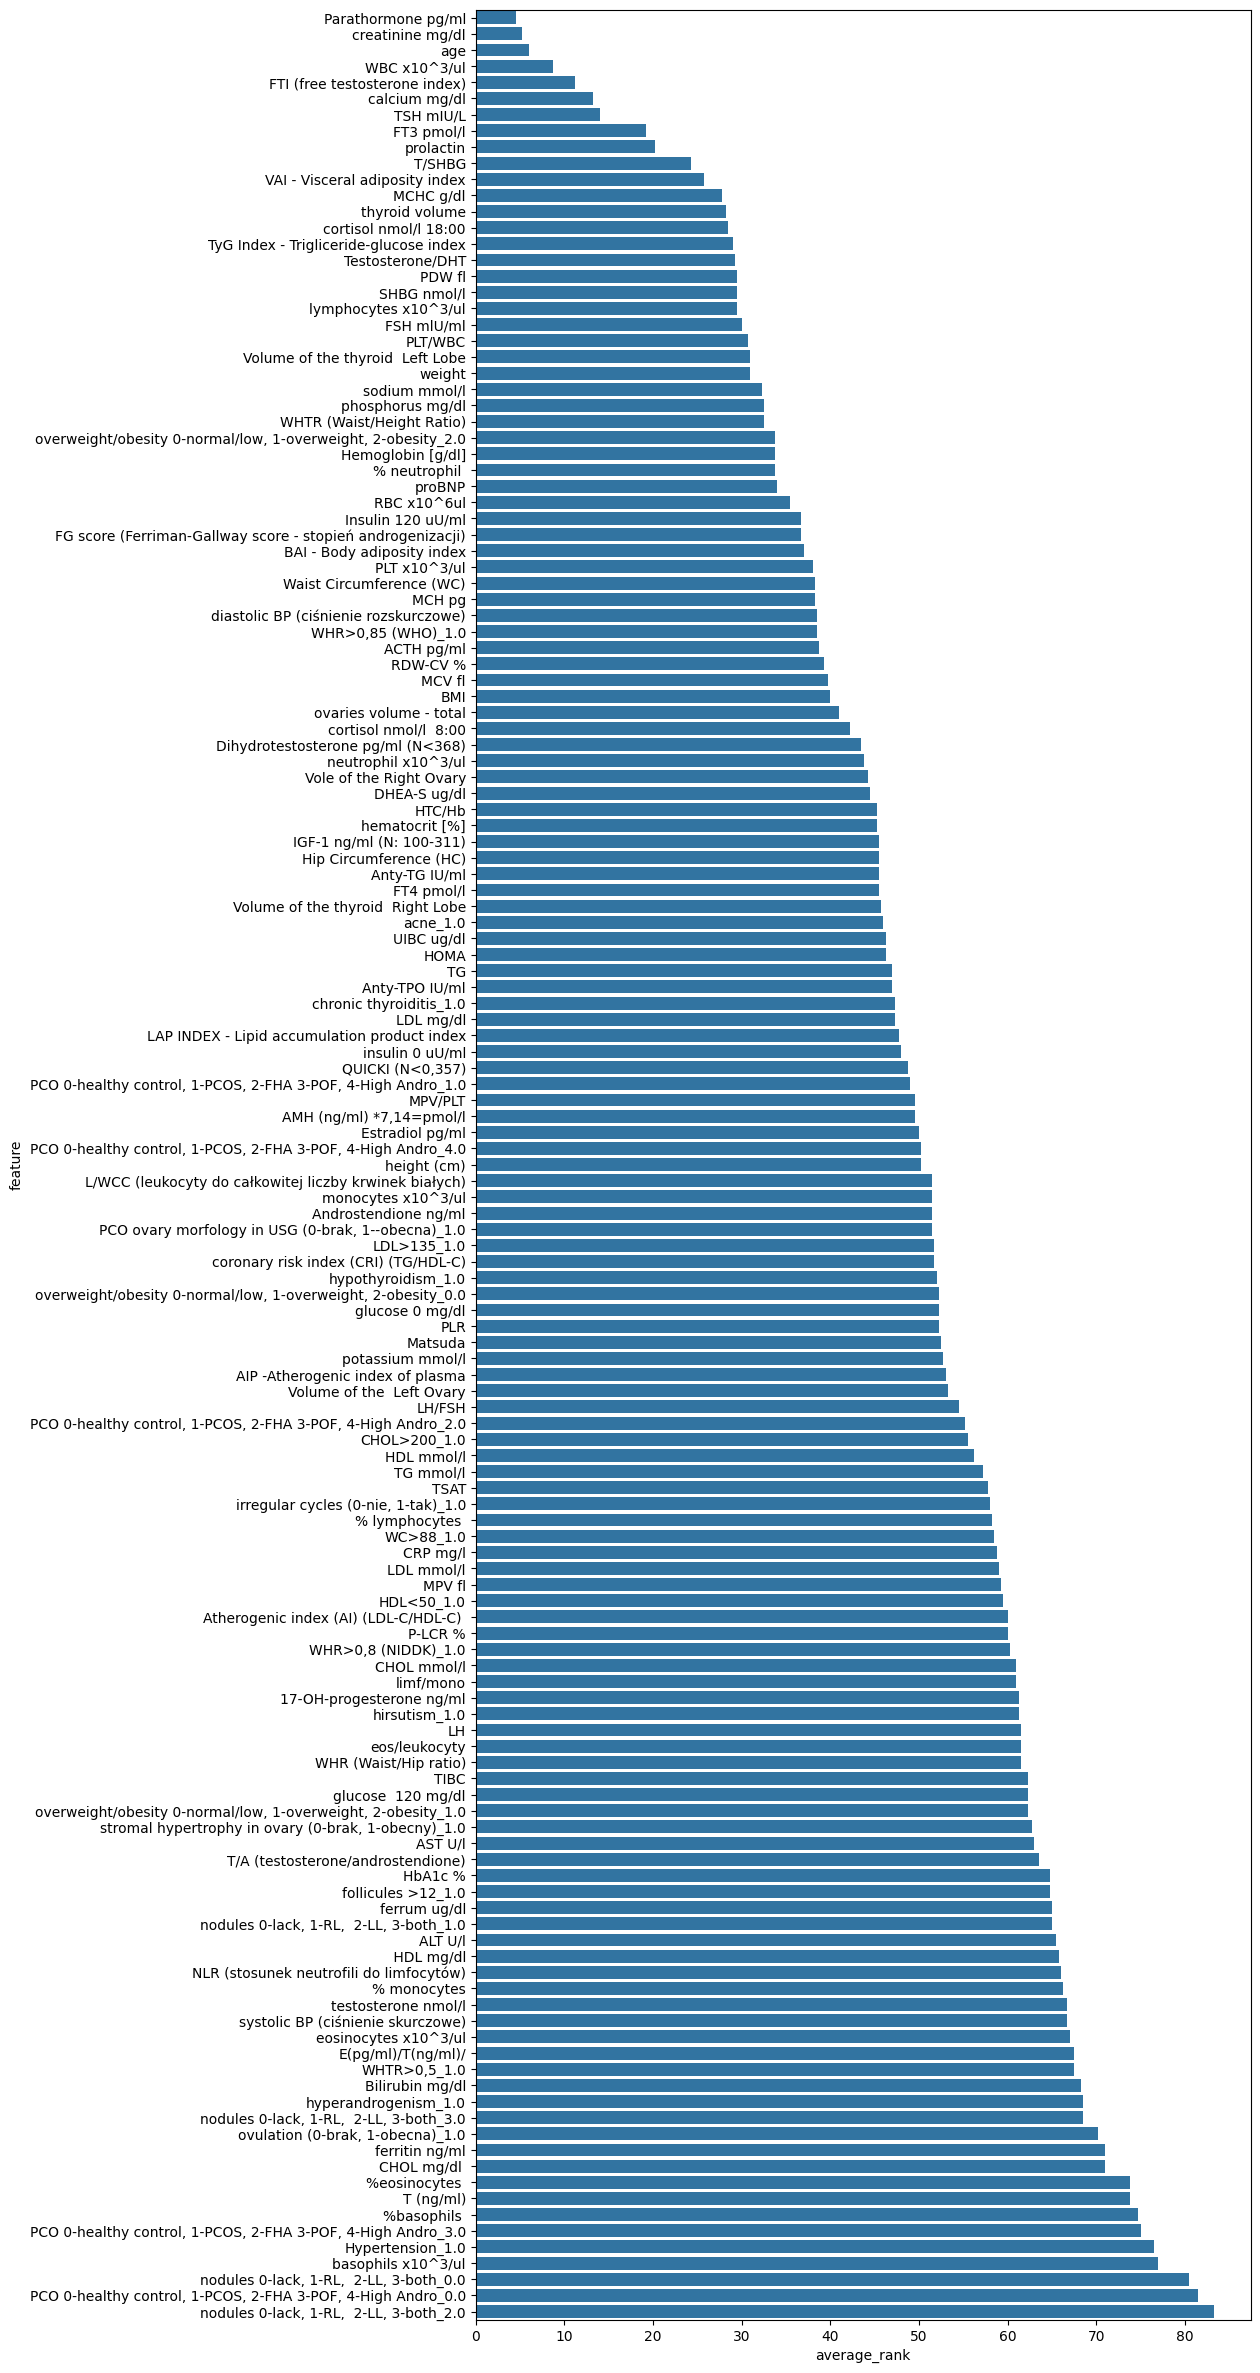

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
67,Parathormone pg/ml,1.0,2.0,12.0,3.0,4.50
104,creatinine mg/dl,2.0,1.0,12.0,6.0,5.25
97,age,4.0,3.0,2.0,15.0,6.00
88,WBC x10^3/ul,5.0,16.0,12.0,2.0,8.75
31,FTI (free testosterone index),14.0,14.0,12.0,5.0,11.25
99,calcium mg/dl,9.0,9.0,12.0,23.0,13.25
79,TSH mIU/L,11.0,19.0,12.0,14.0,14.00
29,FT3 pmol/l,29.0,35.0,12.0,1.0,19.25
136,prolactin,15.0,17.0,10.0,39.0,20.25
74,T/SHBG,49.0,28.0,12.0,8.0,24.25


In [20]:
ranked_df = rank_importances(feature_importance_df)
ranked_df_sorted = ranked_df.sort_values(by='average_rank')

plt.figure(figsize=(10, 30))
sns.barplot(ranked_df_sorted, x="average_rank", y="feature")
plt.show()

ranked_df_sorted

Most important attributes for `vitamin D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)', `WBC x10^3/ul	`, `calcium mg/dl	`, `age`

## Feature selection methods

### Mutual info

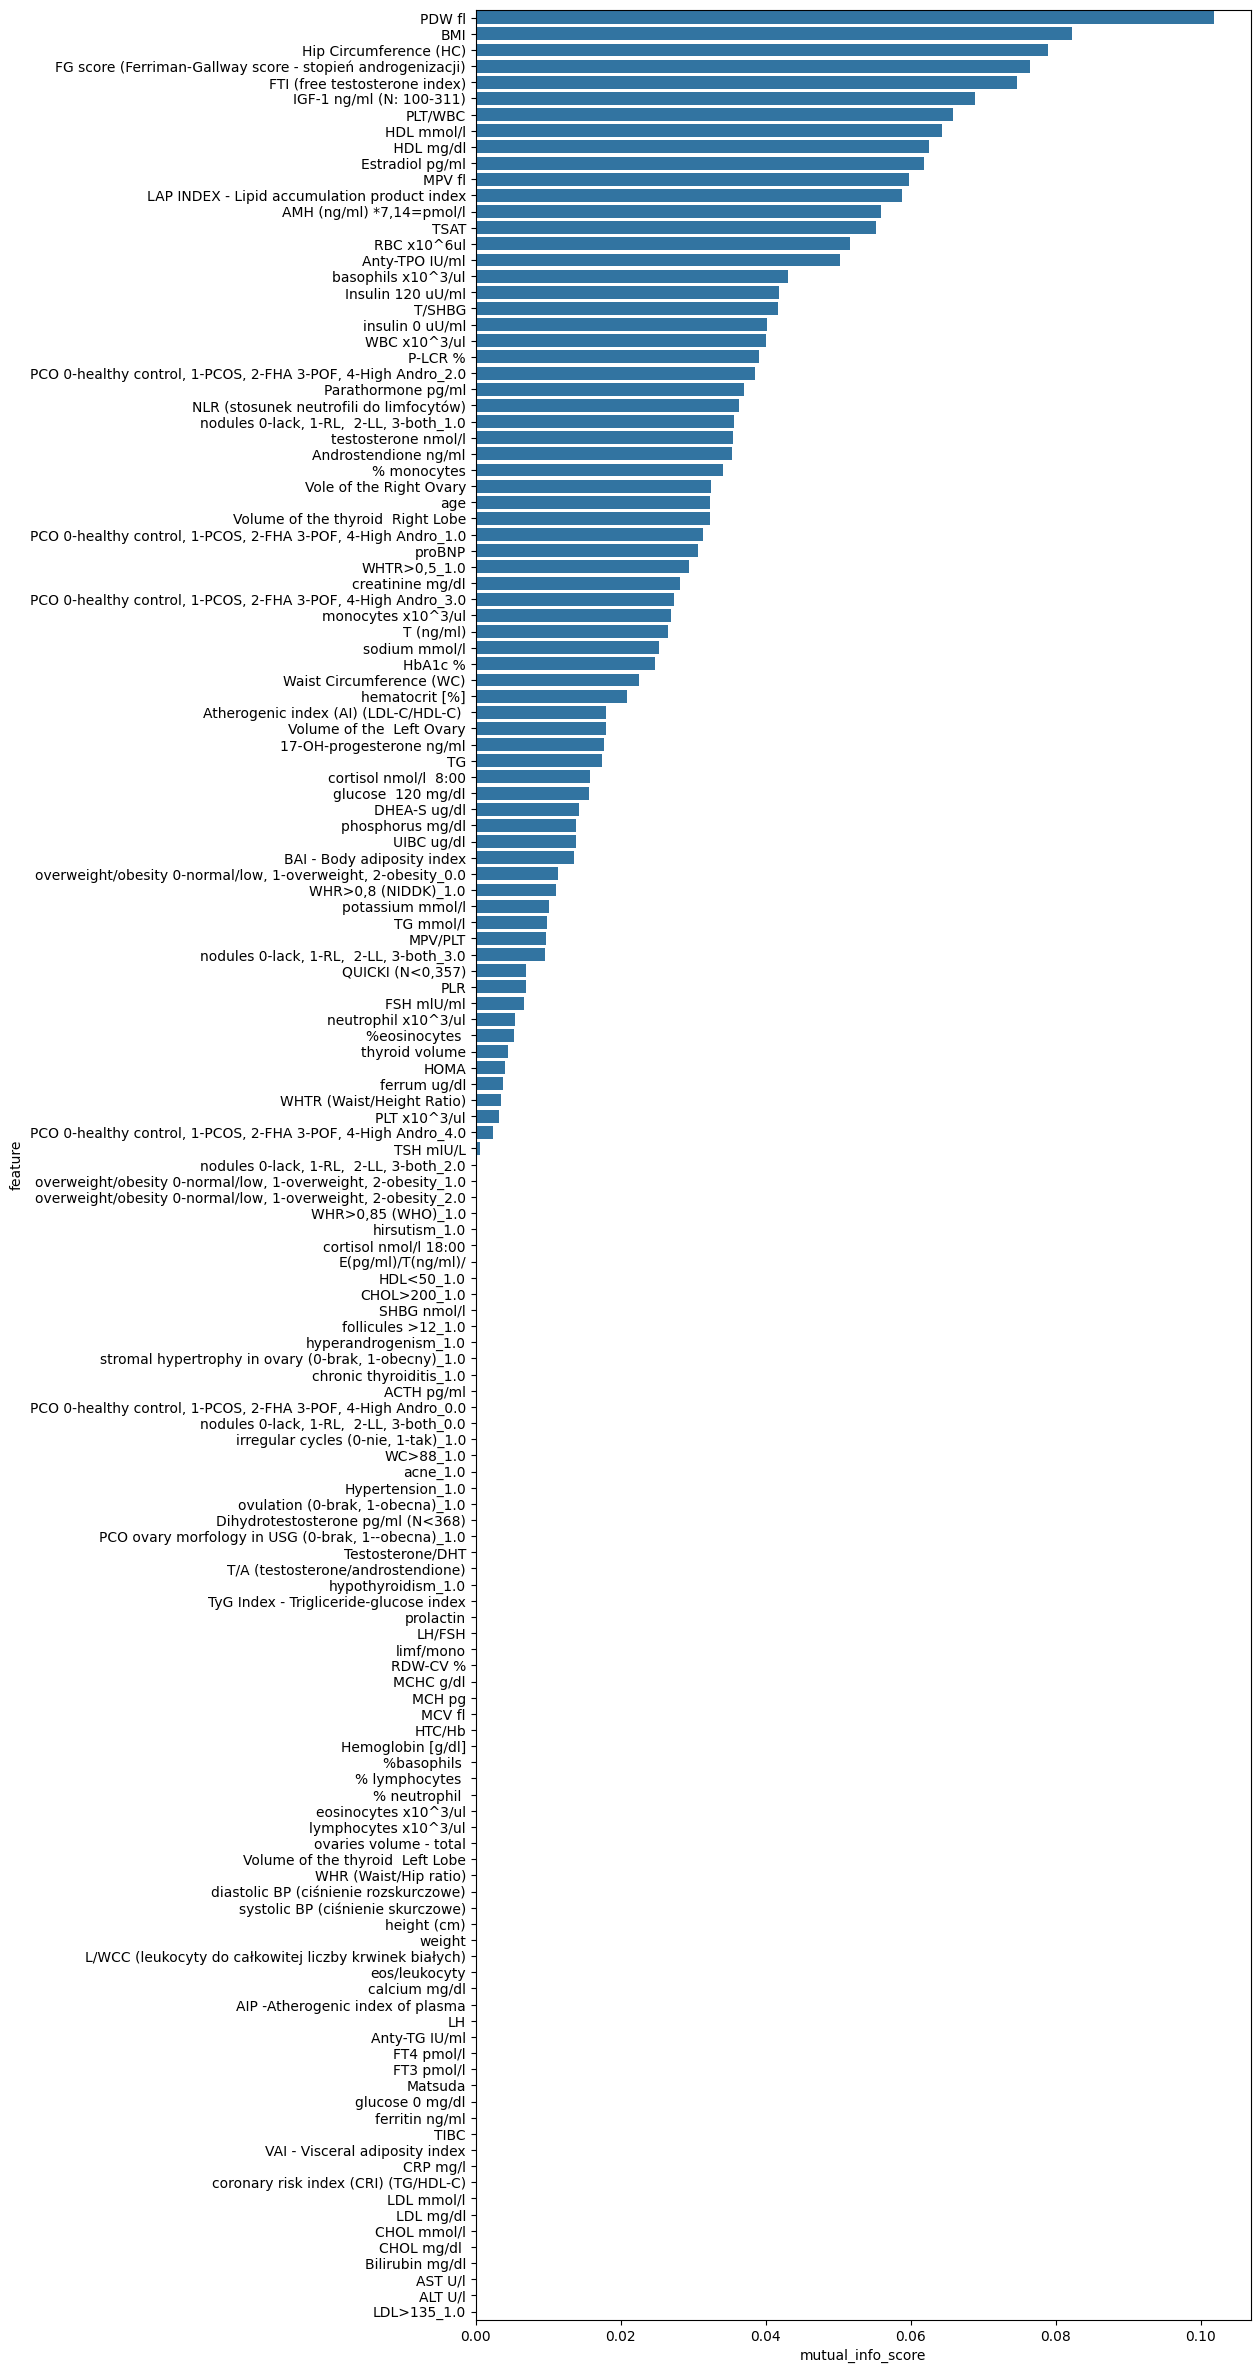

,feature,mutual_info_score
0,PDW fl,0.101813
1,BMI,0.082291
2,Hip Circumference (HC),0.078917
3,FG score (Ferriman-Gallway score - stopień androgenizacji),0.076500
4,FTI (free testosterone index),0.074618
5,IGF-1 ng/ml (N: 100-311),0.068893
6,PLT/WBC,0.065892
7,HDL mmol/l,0.064366
8,HDL mg/dl,0.062589
9,Estradiol pg/ml,0.061886


In [21]:
# def feature_selection_mutual_info_regression(X_train, y_train, target_attribute, continuous_preprocessor, categorical_preprocessor):
#     preprocessor = ColumnTransformer(
#     verbose_feature_names_out=False,
#     transformers=[
#         ('num', continuous_preprocessor, get_continuous_attributes_except(target_attribute)),
#         ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
#     ])

#     pipeline = Pipeline([('preprocessor', preprocessor)])

#     X_transformed = pipeline.fit_transform(X_train, y_train)

#     mutual_info_scores = mutual_info_regression(X_transformed, y_train)
#     feature_names = preprocessor.get_feature_names_out()

#     feature_importances = pd.DataFrame({'feature': feature_names, 'mutual_info_score': mutual_info_scores})
#     feature_importances_sorted = feature_importances.sort_values(by='mutual_info_score', key=abs, ascending=False)

#     plt.figure(figsize=(10, 30))
#     sns.barplot(feature_importances_sorted, x="mutual_info_score", y="feature", legend=False).set(title='alaal)
#     plt.show()

#     return feature_importances_sorted


selected_feature_names_mutual_info = feature_selection_mutual_info_regression(X_train_vit_d, y_train_vit_d, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['mutual_info_score'] > 0]
selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)
selected_feature_names_mutual_info

### Recursive feature elimination

In [72]:
def recursive_feature_elimination(X_train, y_train, model, target_attribute, continuous_preprocessing, categorical_preprocessor, scoring_metric="neg_mean_absolute_error"):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessing, get_continuous_attributes_except(target_attribute)),
            ('cat', categorical_preprocessor, get_categorical_attributes_except(target_attribute))
        ])

    min_features_to_select = 1
    cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
    rfecv = RFECV(
        estimator=model,
        step=1,
        cv=cv,
        scoring=scoring_metric,
        min_features_to_select=min_features_to_select,
        n_jobs=-1,
    )

    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', rfecv)])
    pipeline.fit(X_train, y_train)

    print(f"Optimal number of features: {rfecv.n_features_}")

    ranked_featrures_rfecv = pd.DataFrame({'features': preprocessor.get_feature_names_out(), 'ranking': rfecv.ranking_})
    ranked_featrures_rfecv_ranked = ranked_featrures_rfecv.sort_values(by='ranking').reset_index(drop=True)

    n_scores = len(rfecv.cv_results_["mean_test_score"])
    scores = abs(rfecv.cv_results_["mean_test_score"])

    plt.figure(figsize=(20,10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test score")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        scores,
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title(f"Recursive Feature Elimination \nwith correlated features - {target_attribute}")
    plt.show()
    return ranked_featrures_rfecv_ranked

Optimal number of features: 58


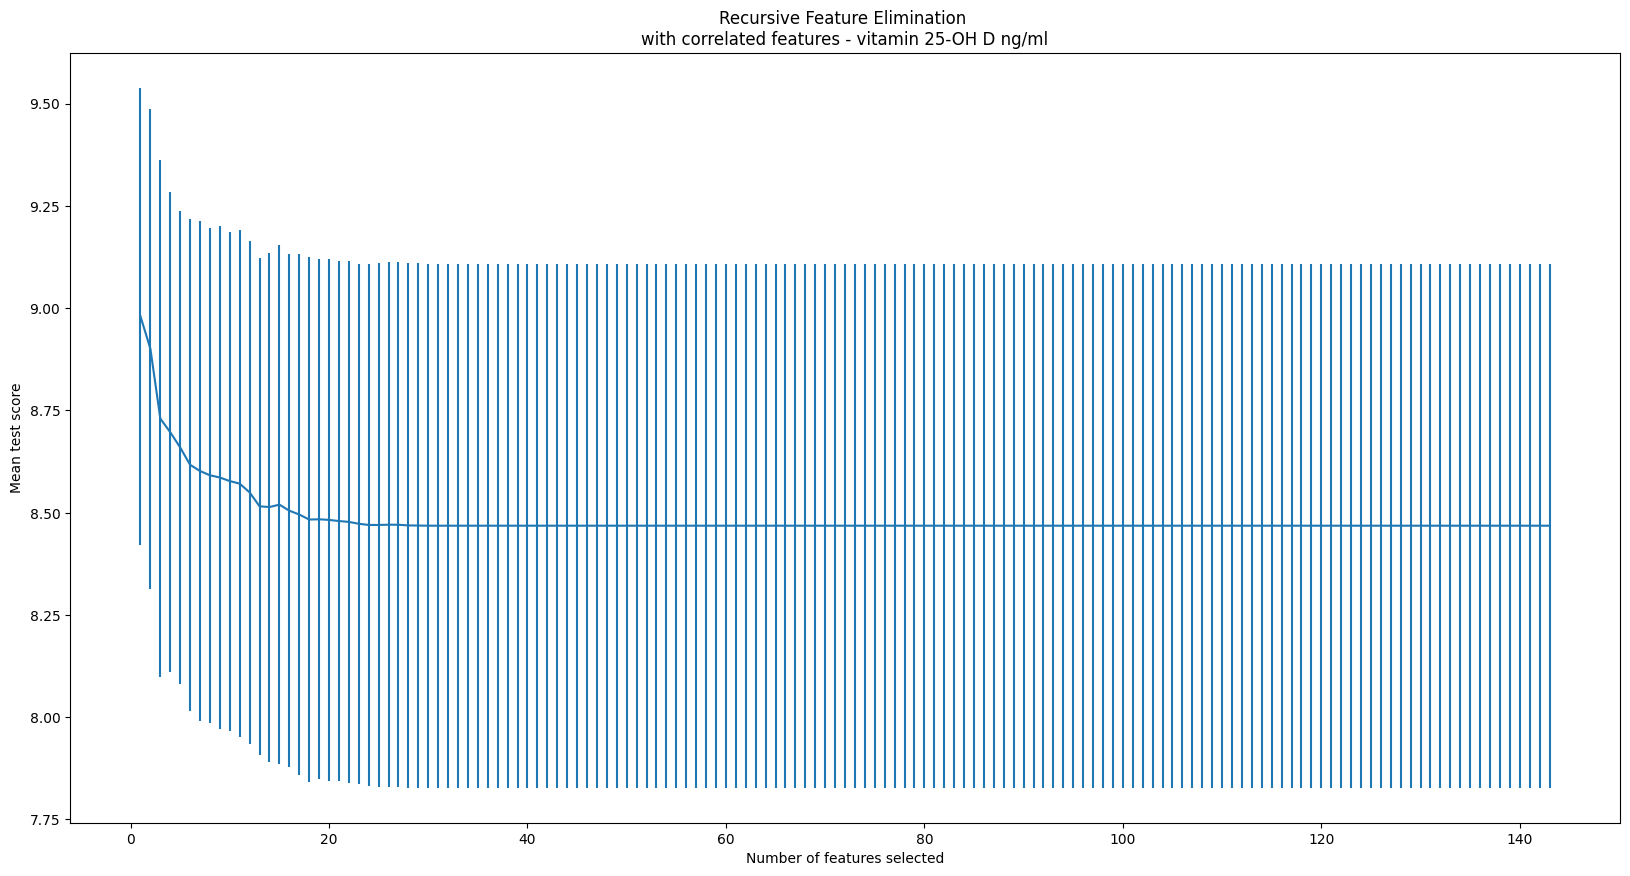

,features,ranking
0,VAI - Visceral adiposity index,1
1,SHBG nmol/l,1
2,FTI (free testosterone index),1
3,Androstendione ng/ml,1
4,Dihydrotestosterone pg/ml (N<368),1
5,Testosterone/DHT,1
6,T/A (testosterone/androstendione),1
7,cortisol nmol/l 18:00,1
8,age,1
9,phosphorus mg/dl,1


In [73]:
lasso_model = Lasso(alpha=0.5)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_vit_d, y_train_vit_d, lasso_model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
recursive_feature_elimination_ranked_features_lasso

Optimal number of features: 88


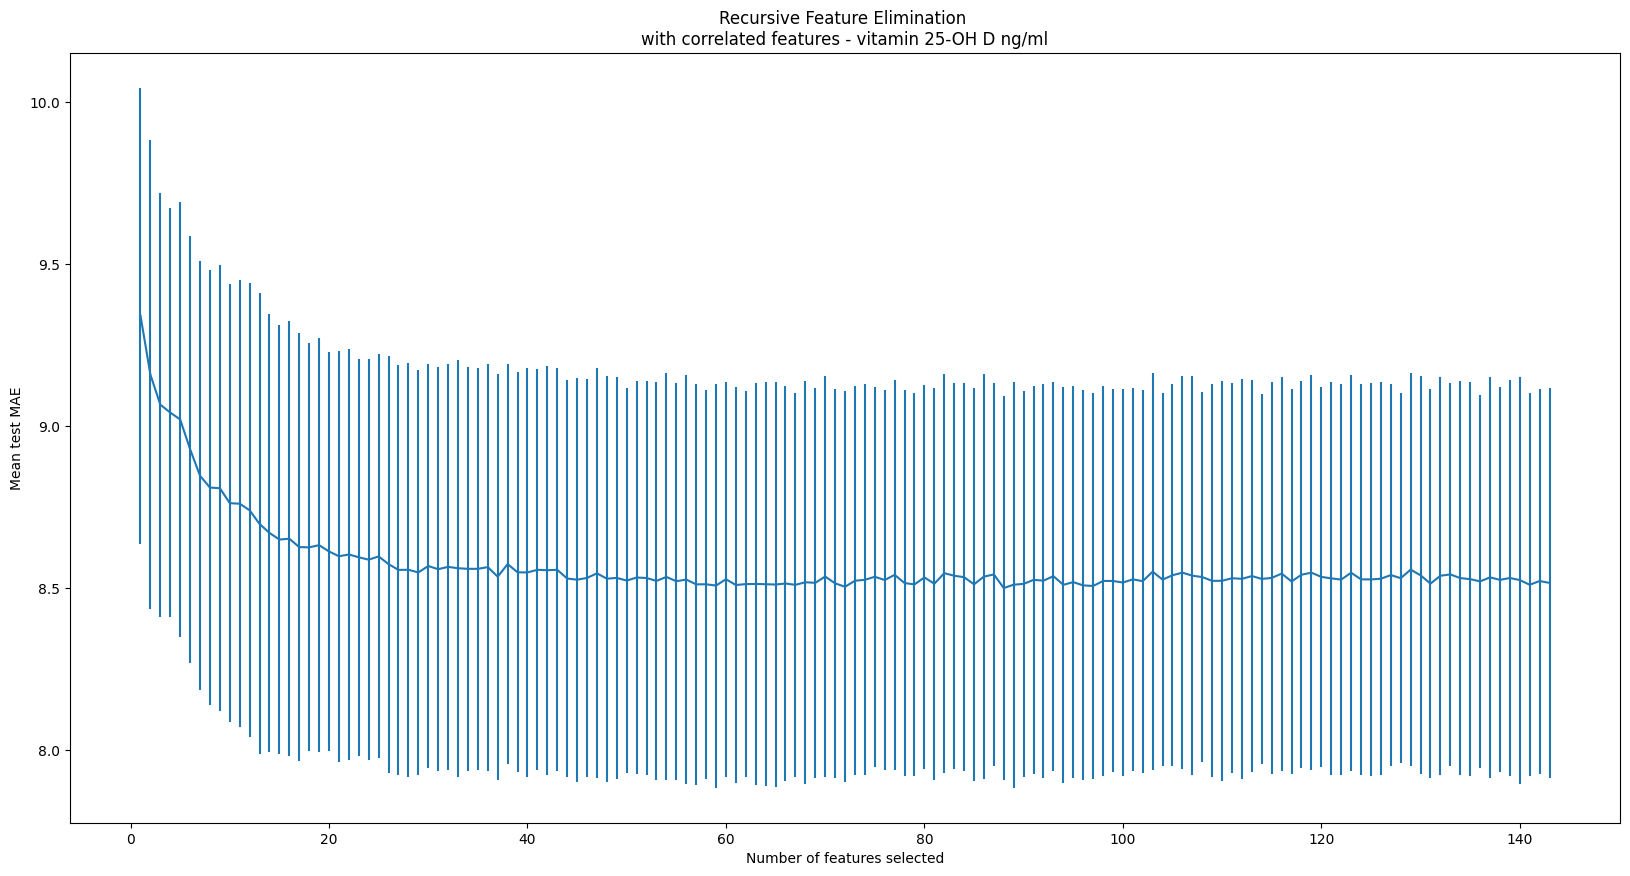

,features,ranking
0,IGF-1 ng/ml (N: 100-311),1
1,HOMA,1
2,Insulin 120 uU/ml,1
3,insulin 0 uU/ml,1
4,glucose 120 mg/dl,1
5,TIBC,1
6,UIBC ug/dl,1
7,AIP -Atherogenic index of plasma,1
8,LAP INDEX - Lipid accumulation product index,1
9,BAI - Body adiposity index,1


In [68]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error')
recursive_feature_elimination_ranked_features_rf = recursive_feature_elimination(X_train_vit_d, y_train_vit_d, rf_model, VITAMINE_D, tree_continuous_preprocessing, categorical_preprocessor)
recursive_feature_elimination_ranked_features_rf

### Permutation importance

In [60]:
# def get_permutation_importance(X_train, y_train, model, continuous_preprocessor, categorical_preprocessor, target_attribute):
#     preprocessor = ColumnTransformer(
#         verbose_feature_names_out=False,
#         transformers=[
#             ('num', continuous_preprocessor, get_continuous_attributes_except(target_attribute)),
#             ('cat', categorical_preprocessor, get_categorical_attributes_except(target_attribute))
#         ])
#     pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

#     pipeline.fit(X_train, y_train)

#     result = permutation_importance(pipeline, X_train, y_train, n_repeats=10,  n_jobs=-1)
#     importances = result.importances_mean
#     importances_std = result.importances_std

#     df_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': importances, 'std': importances_std})

#     df_importances_sorted = df_importances.sort_values(by='importance', ascending=False)

#     permutation_importance_selected_features = df_importances_sorted[df_importances_sorted['importance'] > 0]

#     print(f'selected {len(permutation_importance_selected_features)} features')
#     print(permutation_importance_selected_features)

#     plt.figure(figsize=(10, 30))
#     sns.barplot(df_importances_sorted, x="importance", y="feature", legend=False).set(title=f'Permutation importance - {target_attribute}')
#     plt.show()


In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error')

get_permutation_importance(X_train_vit_d, y_train_vit_d, rf_model, continuous_preprocessor, categorical_preprocessor, VITAMINE_D)

selected 24 features


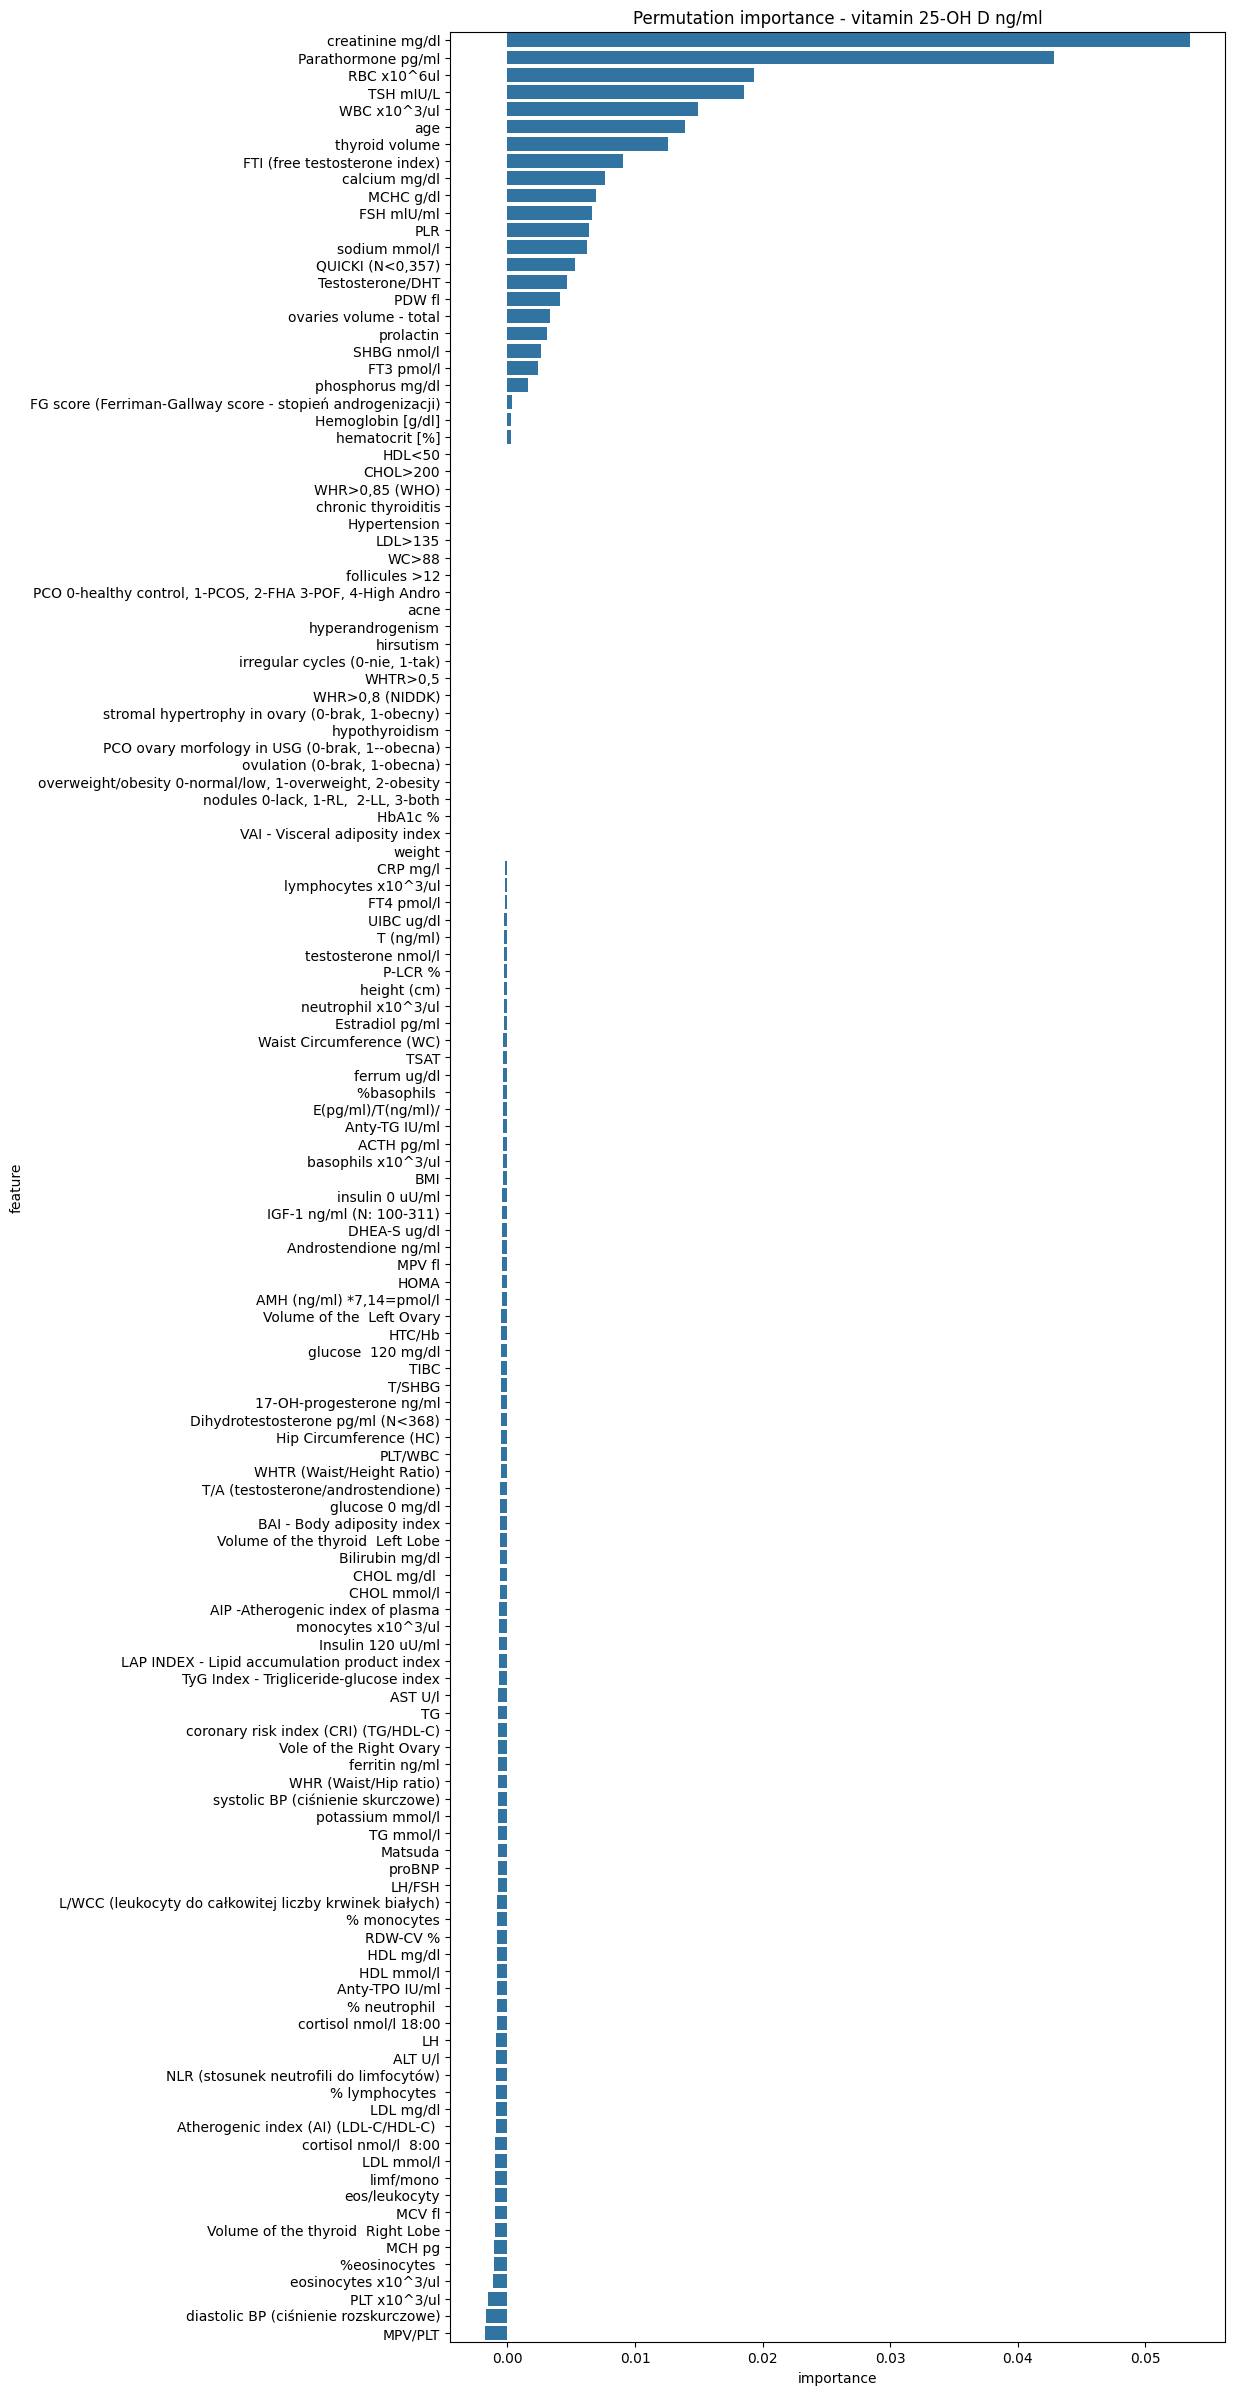

In [59]:
lasso_model = Lasso(alpha=0.5)

get_permutation_importance(X_train_vit_d, y_train_vit_d, lasso_model, continuous_preprocessor, categorical_preprocessor, VITAMINE_D)